# **Mount & imports**

In [ ]:
# Import images from google drive

#connect to google drive - mount
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#imports:
import os
import cv2
import numpy as np
import sys
from IPython.display import Image

In [ ]:
!nvidia-smi

Wed Dec 25 08:58:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


# **YOLOV8**

INSTALL

In [ ]:
# Pip install method (recommended)

!pip install ultralytics==8.2.103 -q

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.7/235.7 GB disk)


In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

roboflow

In [ ]:
!pip install roboflow

from roboflow import Roboflow
import roboflow


!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow --quiet



roboflow.login()

rf = Roboflow(api_key="aCFGMWNyipynQqvPzfaM")

project = rf.workspace("citrus-a0lk2").project("citrus_prediction_data")
dataset = project.version(8).download("yolov8-obb")

import yaml

with open(f'{dataset.location}/data.yaml', 'r') as file:
    data = yaml.safe_load(file)

data['path'] = dataset.location

with open(f'{dataset.location}/data.yaml', 'w') as file:
    yaml.dump(data, file, sort_keys=False)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
/content/datasets
visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Citrus_prediction_data-8 in yolov8-obb:: 100%|██████████| 2350/2350 [00:00<00:00, 7156.07it/s]


f5495a29-a42f-4d16-aec6-7c20c511fb31

calculate how many images in each set

In [ ]:
import os

# Define the paths to the image directories
train_images_path = '/content/datasets/Citrus_prediction_data-8/train/images'
test_images_path = '/content/datasets/Citrus_prediction_data-8/test/images'
valid_images_path = '/content/datasets/Citrus_prediction_data-8/valid/images'

# Function to count the number of image files in a directory
def count_images(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])

# Calculate the number of images in each folder
train_images_count = count_images(train_images_path)
test_images_count = count_images(test_images_path)
valid_images_count = count_images(valid_images_path)

print(f"Number of images in train folder: {train_images_count}")
print(f"Number of images in test folder: {test_images_count}")
print(f"Number of images in valid folder: {valid_images_count}")


Number of images in train folder: 817
Number of images in test folder: 119
Number of images in valid folder: 233


 functions

In [ ]:
import os
import random
import shutil
from collections import defaultdict

#calculate how many objects in each class
def count_objects(label_folder, class_counts):
    """ Count objects in each class from label files in the given directory. """
    label_files = [file for file in os.listdir(label_folder) if file.endswith('.txt')]
    for label_file in label_files:
        label_file_path = os.path.join(label_folder, label_file)
        with open(label_file_path, 'r') as f:
            for line in f:
                class_label = line.strip().split()[0]
                if class_label in class_counts:
                    class_counts[class_label] += 1
                else:
                    class_counts[class_label] = 1
    return class_counts

def print_class_counts(train_label_folder, valid_label_folder, test_label_folder):
    """ Process label folders and print class counts for each dataset. """
    folders = [
        (train_label_folder, "train"),
        (valid_label_folder, "valid"),
        (test_label_folder, "test")
    ]

    total_class_counts = {}

    for folder, folder_name in folders:
        if os.path.exists(folder):
            class_counts = count_objects(folder, {})
            print(f"\nCounts for {folder_name} set:")
            for class_label, count in class_counts.items():
                print(f"Total objects in class '{class_label}': {count}")
                # Update total counts across datasets
                total_class_counts[class_label] = total_class_counts.get(class_label, 0) + count
        else:
            print(f"The directory {folder} does not exist. Please check the path and try again.")

    # Output total counts across all datasets
    print("\nTotal counts across all datasets:")
    for class_label, count in total_class_counts.items():
        print(f"Total objects in class '{class_label}': {count}")



# equlize between classes  - randomly keep images from the main class as the amount of small class  ( same amount of labels)
def debug_balance_label_instances(images_path, labels_path):
    label_instances = defaultdict(list)
    all_labels = defaultdict(int)

    # Read all labels to get an exact count per class
    label_files = os.listdir(labels_path)
    for label_file in label_files:
        with open(os.path.join(labels_path, label_file), 'r') as file:
            lines = file.readlines()
        for line in lines:
            class_id = line.split()[0]
            all_labels[class_id] += 1
            label_instances[class_id].append((label_file, line))

    print("Initial label counts:", dict(all_labels))

    # Find the minimum number of instances to keep per class
    min_instances = min(all_labels.values())

    # Prepare to adjust label files
    adjustments = {class_id: [] for class_id in all_labels}
    for class_id, instances in label_instances.items():
        if len(instances) > min_instances:
            excess = len(instances) - min_instances
            excess_instances = random.sample(instances, excess)
            for inst in excess_instances:
                adjustments[class_id].append(inst)

    # Implement adjustments
    for class_id, items in adjustments.items():
        for label_file, line in items:
            path = os.path.join(labels_path, label_file)
            with open(path, 'r') as file:
                lines = file.readlines()
            if line in lines:
                lines.remove(line)
            with open(path, 'w') as file:
                file.writelines(lines)
            # If file is empty, remove the file and its corresponding image
            if not lines:
                os.remove(path)
                os.remove(os.path.join(images_path, label_file.replace('.txt', '.jpg')))
                print(f"Removed {path} and its image.")

    # Final verification
    final_counts = defaultdict(int)
    label_files = os.listdir(labels_path)
    for label_file in label_files:
        with open(os.path.join(labels_path, label_file), 'r') as file:
            for line in file:
                class_id = line.split()[0]
                final_counts[class_id] += 1

    print("Final label counts after equalization:", dict(final_counts))


In [ ]:
train_label_folder = '/content/datasets/Citrus_prediction_data-8/train/labels'
valid_label_folder = '/content/datasets/Citrus_prediction_data-8/valid/labels'
test_label_folder = '/content/datasets/Citrus_prediction_data-8/test/labels'
print_class_counts(train_label_folder, valid_label_folder, test_label_folder)


Counts for train set:
Total objects in class '1': 841
Total objects in class '0': 32

Counts for valid set:
Total objects in class '0': 11
Total objects in class '1': 232

Counts for test set:
Total objects in class '1': 115
Total objects in class '0': 8

Total counts across all datasets:
Total objects in class '1': 1188
Total objects in class '0': 51


delete if exsist and create dataset_augment and dataset_balanced folders

In [ ]:
import shutil
import os

def duplicate_directory(source_path, target_path):
    """
    Copies the entire directory from source_path to target_path.
    If the target directory already exists, it is deleted and recreated.
    """
    # Check if the target path already exists.
    if os.path.exists(target_path):
        print(f"Target directory {target_path} already exists. Deleting and recreating.")
        shutil.rmtree(target_path)  # Remove the existing directory
        shutil.copytree(source_path, target_path)  # Copy again
        print(f"Directory re-copied from {source_path} to {target_path}.")
    else:
        # Copy the directory if it does not exist
        shutil.copytree(source_path, target_path)
        print(f"Directory copied from {source_path} to {target_path}.")

# Define the source directory and the target directories
source_directory = '/content/datasets'
target_directory_augment = '/content/dataset_augment'
target_directory_balanced = '/content/dataset_balanced'

# Duplicate the source directory to dataset-augment
duplicate_directory(source_directory, target_directory_augment)

# Duplicate the source directory to dataset-balanced
duplicate_directory(source_directory, target_directory_balanced)


Target directory /content/dataset_augment already exists. Deleting and recreating.
Directory re-copied from /content/datasets to /content/dataset_augment.
Target directory /content/dataset_balanced already exists. Deleting and recreating.
Directory re-copied from /content/datasets to /content/dataset_balanced.


# **Augment Data to YOLO**

augment images

In [ ]:
import os
from PIL import Image
import torchvision.transforms as transforms

# Define the paths
train_images_path = '/content/dataset_augment/Citrus_prediction_data-8/train/images'
train_labels_path = '/content/dataset_augment/Citrus_prediction_data-8/train/labels'

# Define augmentation transformations
augment_transforms = transforms.Compose([
    transforms.RandomRotation(360),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(),
])

# Number of augmented copies to create for each class "0" image
num_augmentations = 5  # Set to however many you need

# Function to augment and save images of class "0"
def augment_class_zero_images(images_path, labels_path, num_augmentations):
    label_files = [f for f in os.listdir(labels_path) if f.endswith('.txt')]
    for label_file in label_files:
        label_path = os.path.join(labels_path, label_file)
        with open(label_path, 'r') as file:
            lines = file.readlines()
            if any(line.split()[0] == '0' for line in lines):  # Check if any object is of class "0"
                image_file = label_file.replace('.txt', '.jpg')
                image_path = os.path.join(images_path, image_file)
                if os.path.exists(image_path):
                    image = Image.open(image_path).convert('RGB')
                    for i in range(num_augmentations):
                        augmented_image = augment_transforms(image)
                        new_image_name = f'aug_{i}_{image_file}'
                        new_image_path = os.path.join(images_path, new_image_name)
                        new_label_path = os.path.join(labels_path, new_image_name.replace('.jpg', '.txt'))
                        augmented_image.save(new_image_path)
                        with open(new_label_path, 'w') as new_label_file:
                            new_label_file.writelines(lines)

# Run the function
augment_class_zero_images(train_images_path, train_labels_path, num_augmentations)


In [ ]:
train_images_path = '/content/dataset_augment/Citrus_prediction_data-8/train/images'
train_labels_path = '/content/dataset_augment/Citrus_prediction_data-8/train/labels'
debug_balance_label_instances(train_images_path, train_labels_path)

Initial label counts: {'1': 841, '0': 192}
Removed /content/dataset_augment/Citrus_prediction_data-8/train/labels/1D3A5550_JPG.rf.b7159558fe9b55fed9376b5e2f324518.txt and its image.
Removed /content/dataset_augment/Citrus_prediction_data-8/train/labels/1D3A5619_JPG.rf.5a5b238ff4cc08e17ad79fb40f496084.txt and its image.
Removed /content/dataset_augment/Citrus_prediction_data-8/train/labels/1D3A5561_JPG.rf.3b1ceb64f17d4a0d1ceec1b2ee37bd28.txt and its image.
Removed /content/dataset_augment/Citrus_prediction_data-8/train/labels/1D3A4824_JPG.rf.680a8691eb0a2fc9eb54075d1f53919f.txt and its image.
Removed /content/dataset_augment/Citrus_prediction_data-8/train/labels/1D3A5475_JPG.rf.03415db99f63491f43e1e53225050b8e.txt and its image.
Removed /content/dataset_augment/Citrus_prediction_data-8/train/labels/1D3A4391_JPG.rf.db6dd5e3d82fdf6543cb30fbf0927a3a.txt and its image.
Removed /content/dataset_augment/Citrus_prediction_data-8/train/labels/1D3A3385_JPG.rf.0179d7789ab204cf2ff63574b1729950.txt

balane the data - randomly delete images from the massive class and equlize to the small class

In [ ]:
train_label_folder = '/content/dataset_augment/Citrus_prediction_data-8/train/labels'
valid_label_folder = '/content/dataset_augment/Citrus_prediction_data-8/valid/labels'
test_label_folder = '/content/dataset_augment/Citrus_prediction_data-8/test/labels'
print_class_counts(train_label_folder, valid_label_folder, test_label_folder)


Counts for train set:
Total objects in class '1': 192
Total objects in class '0': 192

Counts for valid set:
Total objects in class '0': 11
Total objects in class '1': 232

Counts for test set:
Total objects in class '1': 115
Total objects in class '0': 8

Total counts across all datasets:
Total objects in class '1': 539
Total objects in class '0': 211


In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/dataset_augment

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/dataset_augment


change yaml file

In [ ]:
import yaml

# Define the path to your existing data.yaml file
yaml_path = '/content/dataset_augment/Citrus_prediction_data-8/data.yaml'

# Read the existing data.yaml
with open(yaml_path, 'r') as yaml_file:
    data = yaml.safe_load(yaml_file)

# Update the 'path' key
data['path'] = '/content/dataset_augment/Citrus_prediction_data-8'

# Write the updated data back to data.yaml
with open(yaml_path, 'w') as yaml_file:
    yaml.safe_dump(data, yaml_file, default_flow_style=False)

print("data.yaml has been updated successfully.")


data.yaml has been updated successfully.


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n-obb.pt')

results = model.train(data=f"{dataset.location}/data.yaml", epochs=10, imgsz=640)

100%|██████████| 6.26M/6.26M [00:00<00:00, 98.8MB/s]

New https://pypi.org/project/ultralytics/8.3.53 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=obb, mode=train, model=yolov8n-obb.pt, data=/content/datasets/Citrus_prediction_data-8/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, emb

100%|██████████| 755k/755k [00:00<00:00, 20.2MB/s]


Overriding model.yaml nc=15 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 116MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/Citrus_prediction_data-8/train/labels... 817 images, 0 backgrounds, 0 corrupt: 100%|██████████| 817/817 [00:00<00:00, 1703.54it/s]

train: New cache created: /content/datasets/Citrus_prediction_data-8/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/datasets/Citrus_prediction_data-8/valid/labels... 233 images, 0 backgrounds, 0 corrupt: 100%|██████████| 233/233 [00:00<00:00, 1324.19it/s]


val: New cache created: /content/datasets/Citrus_prediction_data-8/valid/labels.cache
Plotting labels to runs/obb/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/obb/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.34G     0.8624      1.944      2.629          1        640: 100%|██████████| 52/52 [00:20<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.20it/s]

                   all        233        243      0.891      0.491      0.517      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.21G     0.5159     0.8332      2.284          1        640: 100%|██████████| 52/52 [00:15<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


                   all        233        243       0.97      0.485      0.558      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.21G     0.4208     0.5895      2.171          1        640: 100%|██████████| 52/52 [00:14<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]

                   all        233        243      0.585      0.535      0.578      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.21G     0.3894     0.5111      2.117          1        640: 100%|██████████| 52/52 [00:14<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]

                   all        233        243       0.53      0.894      0.587      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.21G      0.355     0.4469      2.105          1        640: 100%|██████████| 52/52 [00:14<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


                   all        233        243      0.941      0.669       0.72      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.21G     0.3517     0.4339      2.113          1        640: 100%|██████████| 52/52 [00:14<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]

                   all        233        243      0.699      0.831      0.771      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.21G     0.3095     0.3701       2.11          1        640: 100%|██████████| 52/52 [00:15<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]

                   all        233        243      0.833      0.675      0.828      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.21G     0.2966     0.3638      2.127          1        640: 100%|██████████| 52/52 [00:15<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.29it/s]

                   all        233        243      0.833      0.674      0.706        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.21G     0.2716     0.3652      2.085          1        640: 100%|██████████| 52/52 [00:15<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.93it/s]

                   all        233        243      0.749      0.752      0.691      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.21G     0.2592     0.3249       2.13          1        640: 100%|██████████| 52/52 [00:16<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.89it/s]

                   all        233        243        0.8      0.758      0.779      0.759



10 epochs completed in 0.058 hours.
Optimizer stripped from runs/obb/train/weights/last.pt, 6.6MB
Optimizer stripped from runs/obb/train/weights/best.pt, 6.6MB

Validating runs/obb/train/weights/best.pt...
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-obb summary (fused): 187 layers, 3,077,609 parameters, 0 gradients, 8.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


                   all        233        243      0.833      0.675      0.828      0.811
      Cracked_Mandarin         11         11      0.767      0.364      0.672      0.663
              Mandarin        222        232      0.898      0.986      0.984      0.959
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to runs/obb/train


In [ ]:
model = YOLO('/content/dataset_augment/runs/obb/train/weights/best.pt')

import os
import random

random_file = random.choice(os.listdir(f"{dataset.location}/test/images"))
file_name = os.path.join(f"{dataset.location}/test/images", random_file)

results = model(file_name)

print(results[0])


image 1/1 /content/datasets/Citrus_prediction_data-8/test/images/1D3A4452_JPG.rf.d63326e751f92b4678161cced60f6973.jpg: 640x640 16.8ms
Speed: 2.2ms preprocess, 16.8ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)
ultralytics.engine.results.Results object with attributes:

boxes: None
keypoints: None
masks: None
names: {0: 'Cracked_Mandarin', 1: 'Mandarin'}
obb: ultralytics.engine.results.OBB object
orig_img: array([[[ 71, 124, 121],
        [ 71, 124, 121],
        [ 69, 124, 121],
        ...,
        [ 41,  83,  82],
        [ 40,  78,  78],
        [ 38,  76,  76]],

       [[ 71, 124, 121],
        [ 71, 124, 121],
        [ 69, 124, 121],
        ...,
        [ 36,  78,  77],
        [ 35,  75,  74],
        [ 35,  73,  73]],

       [[ 71, 124, 121],
        [ 71, 124, 121],
        [ 69, 124, 121],
        ...,
        [ 33,  75,  74],
        [ 33,  73,  72],
        [ 32,  72,  71]],

       ...,

       [[158, 165, 160],
        [158, 165, 160],
        [16

augment class 0 - old

In [ ]:
import cv2
import os
import numpy as np
from PIL import Image, ImageEnhance
import shutil

def add_gaussian_noise(image):
    row, col, ch = image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = image + gauss
    return np.clip(noisy, 0, 255).astype(np.uint8)

def augment_image(image_path, method):
    # Load the original image
    image = cv2.imread(image_path)
    pil_img = Image.open(image_path)

    if method == 'gaussian_small':
        blurred = cv2.GaussianBlur(image, (5, 5), 0)
        return Image.fromarray(blurred)
    elif method == 'gaussian_large':
        blurred = cv2.GaussianBlur(image, (11, 11), 0)
        return Image.fromarray(blurred)
    elif method == 'median':
        # Apply Median Blur
        blurred = cv2.medianBlur(image, 5)
        return Image.fromarray(blurred)
    elif method == 'noise':
        noisy = add_gaussian_noise(image)
        return Image.fromarray(noisy)
    elif method == 'brighten':
        enhancer = ImageEnhance.Brightness(pil_img)
        return enhancer.enhance(1.5)

def process_images(label_folder, image_folder):
    for label_file in os.listdir(label_folder):
        if label_file.endswith('.txt'):
            label_path = os.path.join(label_folder, label_file)
            with open(label_path, 'r') as file:
                if any('0' in line.split()[0] for line in file):
                    image_file = label_file.replace('.txt', '.jpg')
                    image_path = os.path.join(image_folder, image_file)

                    for aug_method in ['gaussian_small', 'gaussian_large', 'median', 'noise', 'brighten']:
                        augmented_image = augment_image(image_path, aug_method)
                        if augmented_image is not None:
                            new_image_name = image_file.replace('.jpg', f'_{aug_method}.jpg')
                            new_label_name = label_file.replace('.txt', f'_{aug_method}.txt')

                            # Save the augmented image
                            augmented_image.save(os.path.join(image_folder, new_image_name))
                            # Copy the original label file for the augmented image
                            shutil.copy(label_path, os.path.join(label_folder, new_label_name))

# Directory setup
label_folder = '/content/datasets/Citrus_prediction_data-8/train/labels'
image_folder = '/content/datasets/Citrus_prediction_data-8/train/images'

# Function call
process_images(label_folder, image_folder)


calculate how many object in train in each class after augmentation

In [ ]:
import os

# Function to count objects in each class
def count_objects(label_folder):
    # Initialize a dictionary to hold the count of each class
    class_counts = {'0': 0, '1': 0}

    # List all label files in the label folder
    label_files = [file for file in os.listdir(label_folder) if file.endswith('.txt')]

    # Loop through each label file and count classes
    for label_file in label_files:
        label_file_path = os.path.join(label_folder, label_file)
        with open(label_file_path, 'r') as f:
            for line in f:
                class_label = line.strip().split()[0]
                if class_label in class_counts:
                    class_counts[class_label] += 1
    return class_counts

# Correct path as confirmed by the user
train_label_folder = '/content/yolov9/Citrus_prediction_data-6/train/labels'

# Ensure the path exists before proceeding
if os.path.exists(train_label_folder):
    # Count the number of objects in each class
    class_counts = count_objects(train_label_folder)

    # Output the counts
    for class_label, count in class_counts.items():
        print(f"Total objects in class '{class_label}': {count}")
else:
    print(f"The directory {train_label_folder} does not exist. Please check the path and try again.")


Total objects in class '0': 648
Total objects in class '1': 2505


calculate how many images in total we have now

In [ ]:
import os

# Define the paths to the image directories
train_images_path = '/content/yolov9/Citrus_prediction_data-6/train/images'
test_images_path = '/content/yolov9/Citrus_prediction_data-6/test/images'
valid_images_path = '/content/yolov9/Citrus_prediction_data-6/valid/images'

# Function to count the number of image files in a directory
def count_images(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])

# Calculate the number of images in each folder
train_images_count = count_images(train_images_path)
test_images_count = count_images(test_images_path)
valid_images_count = count_images(valid_images_path)

print(f"Number of images in train folder: {train_images_count}")
print(f"Number of images in test folder: {test_images_count}")
print(f"Number of images in valid folder: {valid_images_count}")


Number of images in train folder: 2972
Number of images in test folder: 119
Number of images in valid folder: 233


In [ ]:
!python /content/yolov9/train.py \
--batch 16 --epochs 10 --img 640 --device 0 --min-items 0 --close-mosaic 15 --patience 5\
--data /content/yolov9/Citrus_3
prediction_data-6/data.yaml \
--weights /content/yolov9/gelan-c.pt \
--cfg /content/yolov9/models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml


2024-12-04 07:47:30.041690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 07:47:30.065372: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 07:47:30.072299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 07:47:30.088462: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 07:47:31.469720: W tensorflow/comp

In [ ]:
ls /content/yolov9/valid/images


ls: cannot access '/content/yolov9/valid/images': No such file or directory


*Visualize training results

In [ ]:
from IPython.display import Image

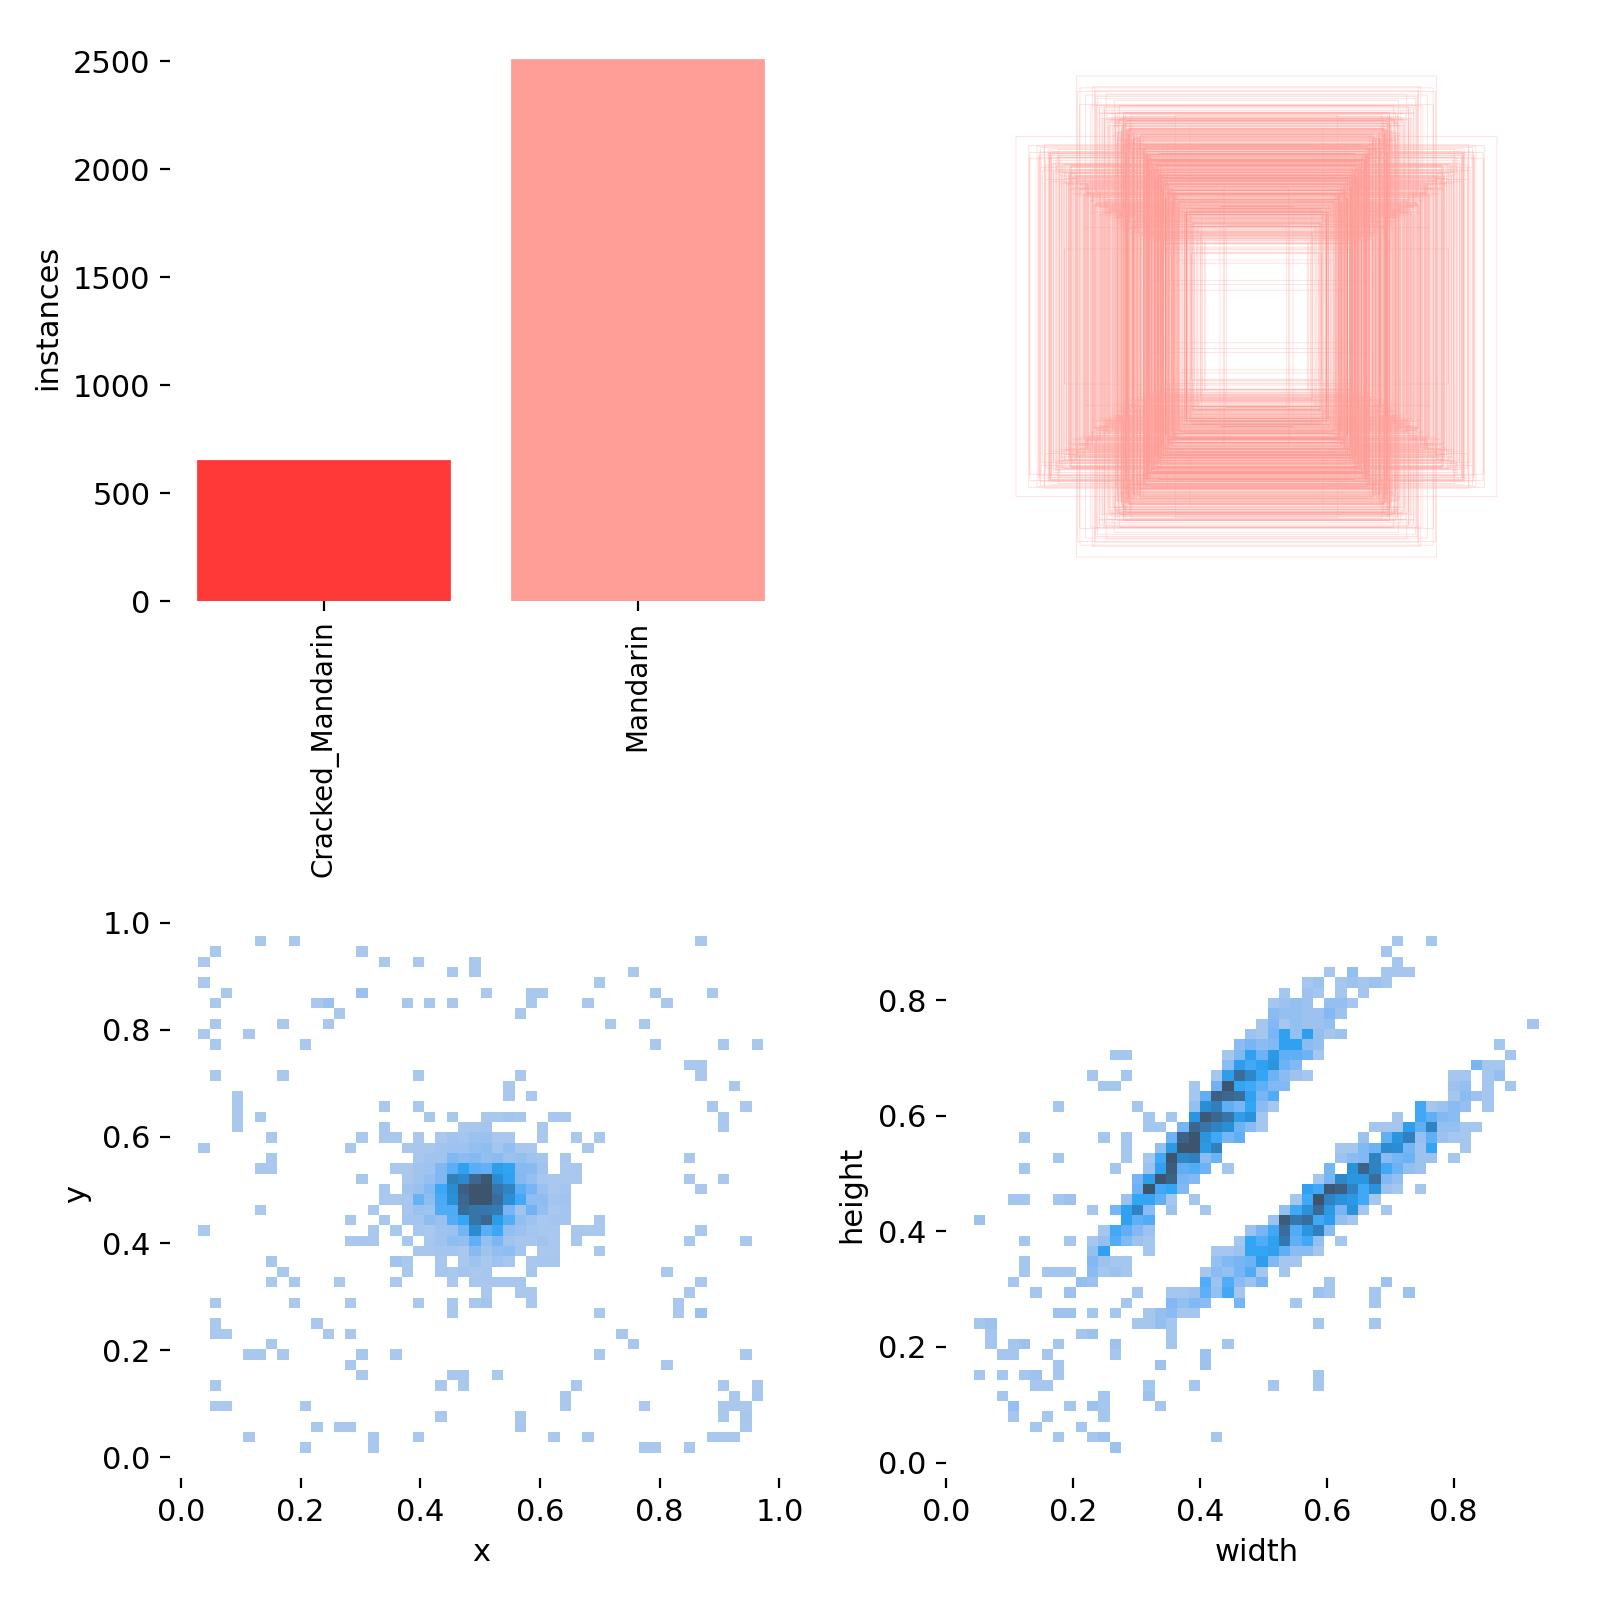

In [ ]:
Image(filename=f"/content/yolov9/runs/train/exp5/labels.jpg", width=1000)

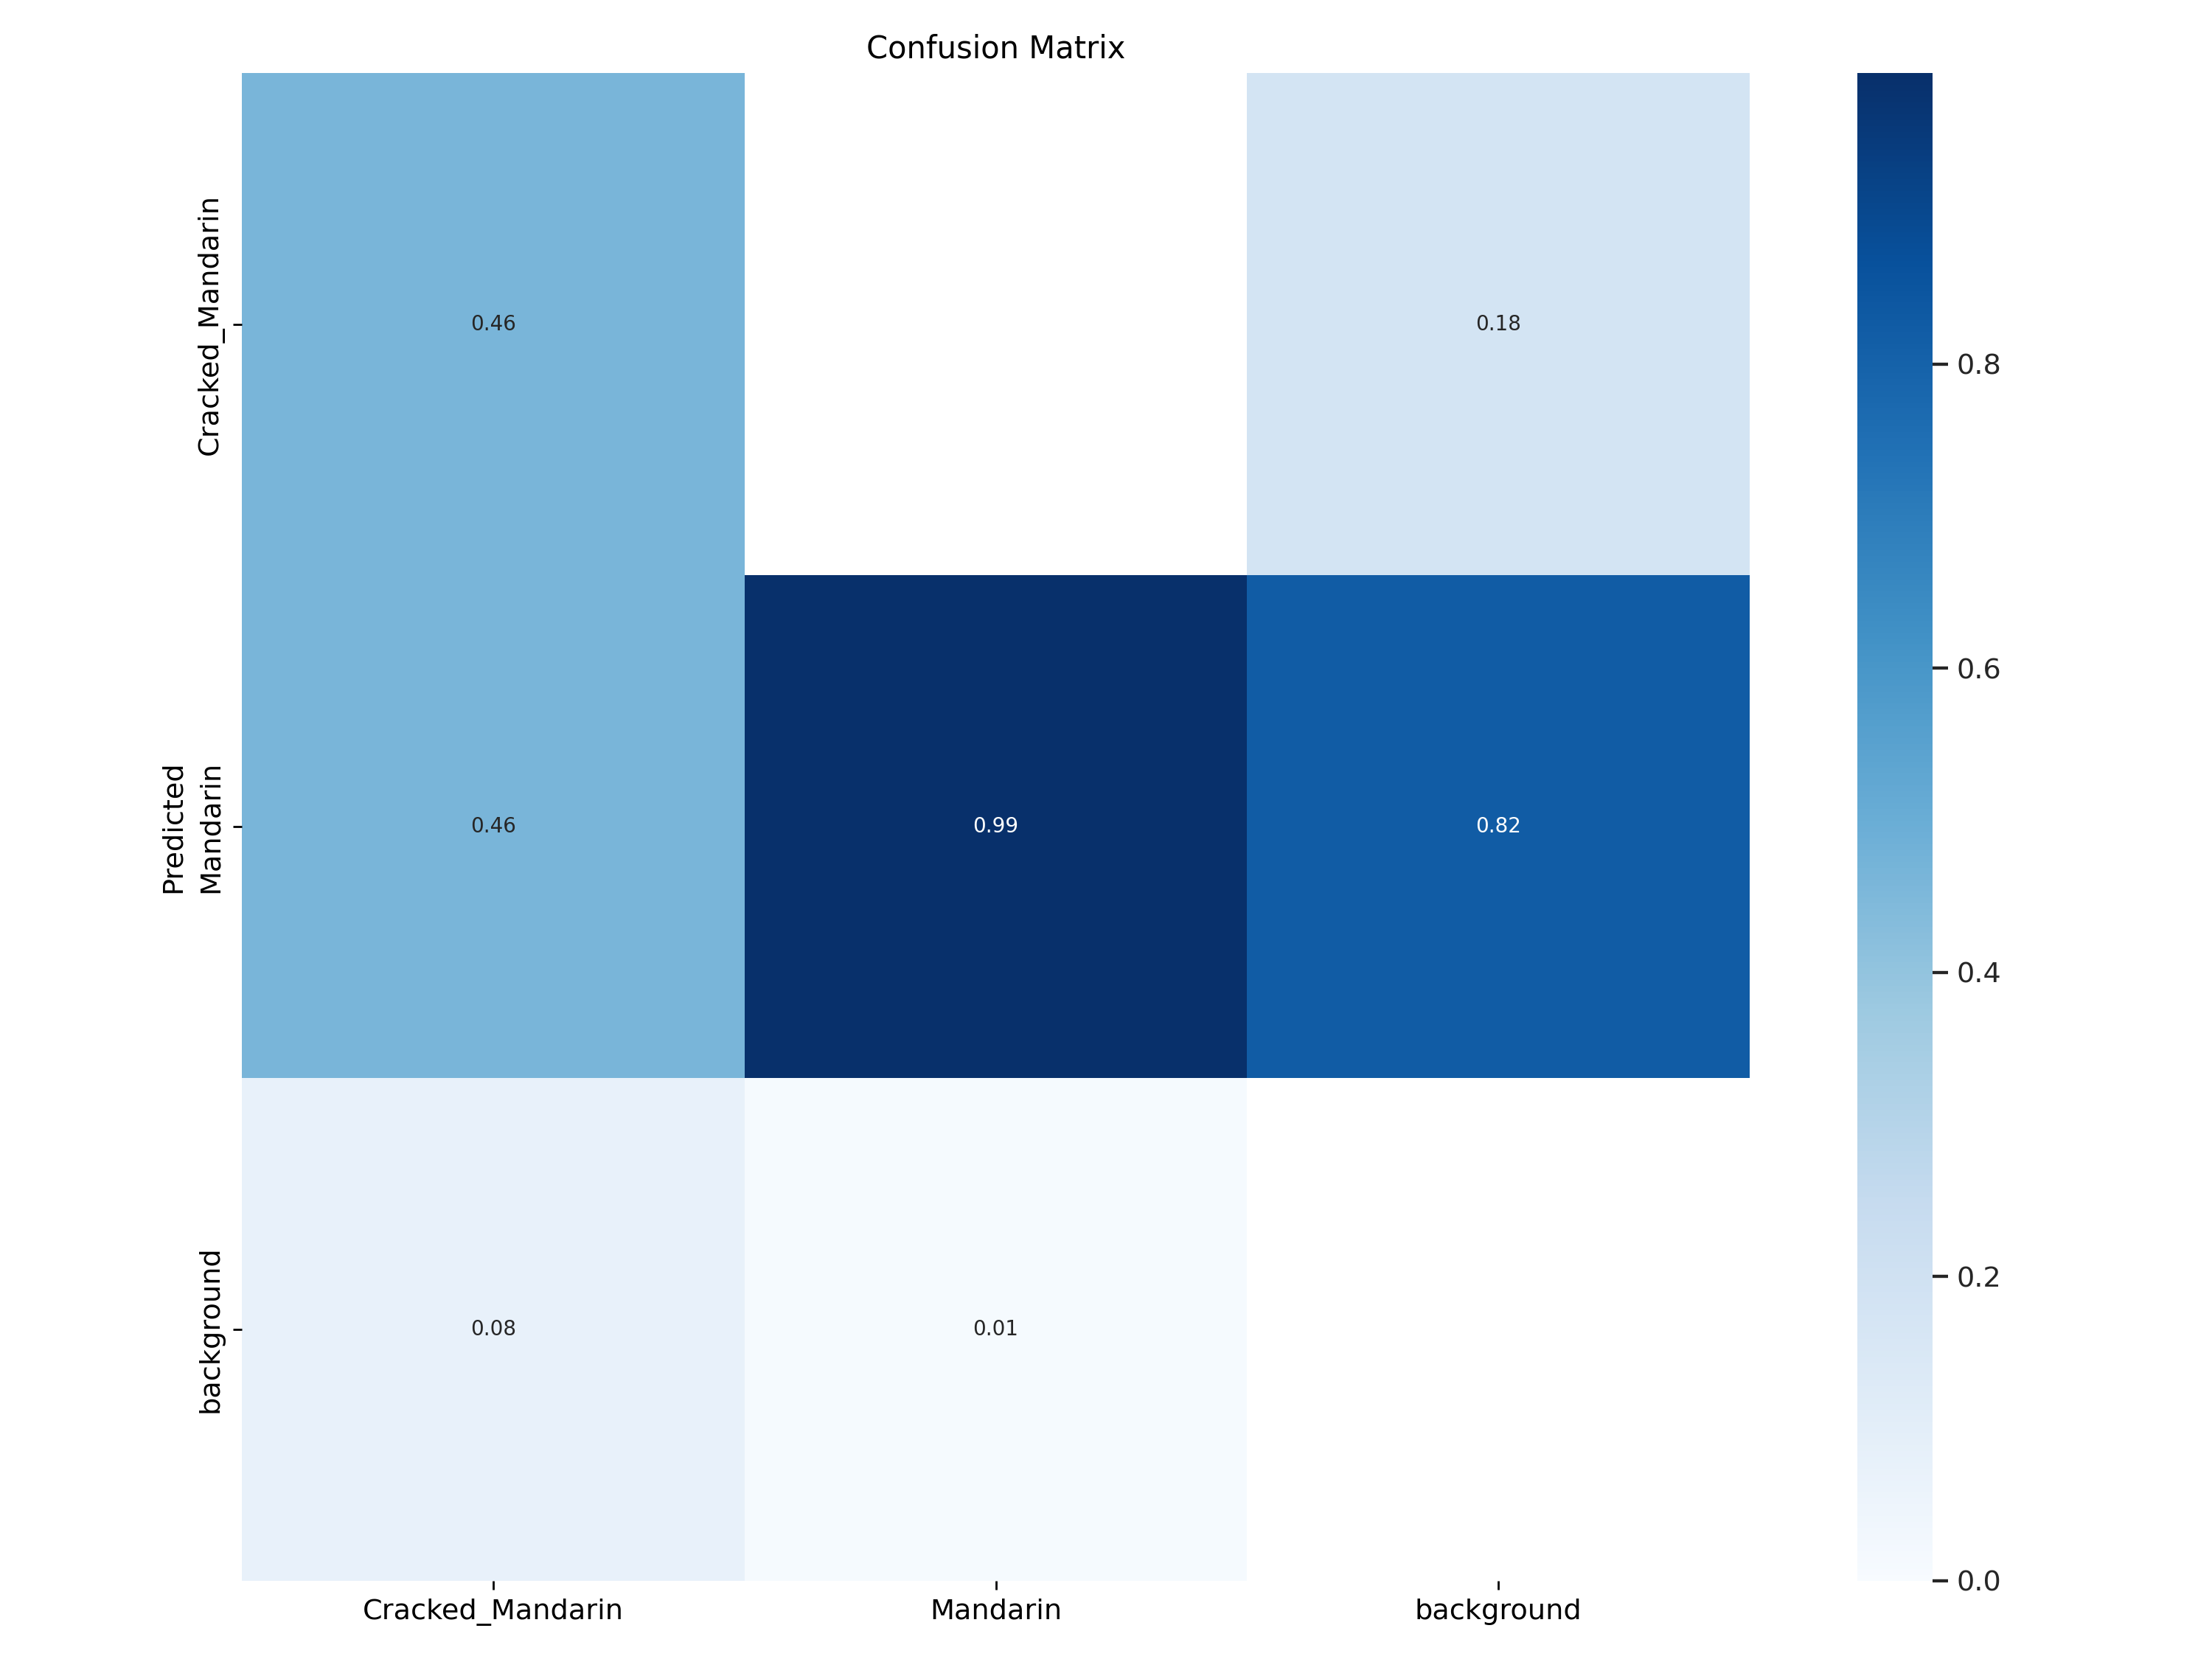

In [ ]:
Image(filename=f"/content/yolov9/runs/train/exp5/confusion_matrix.png", width=1000)

detect conf 0.1

In [ ]:
!python /content/yolov9/detect.py --img 1280 --conf 0.1 --device 0 --weights /content/yolov9/runs/train/exp/weights/best.pt --source /content/Citrus_prediction_data-6/test/images --save-txt --save-conf


detect: weights=['/content/yolov9/runs/train/exp/weights/best.pt'], source=/content/Citrus_prediction_data-6/test/images, data=yolov9/data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov9/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Traceback (most recent call last):
  File "/content/yolov9/detect.py", line 232, in <module>
    main(opt)
  File "/content/yolov9/detect.py", line 227, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/content/yolov9/detect.py", line 68, in run
    model = Dete

try on images for detection task

In [ ]:
!python /content/yolov9/detect.py --img 1280 --conf 0.1 --device 0 --weights /content/yolov9/runs/train/exp2/weights/best.pt --source /content/gdrive/MyDrive/Thesis/Images/20231216/detection/RGB --save-txt --save-conf


detect: weights=['/content/yolov9/runs/train/exp2/weights/best.pt'], source=/content/gdrive/MyDrive/Thesis/Images/20231216/detection/RGB, data=yolov9/data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov9/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Traceback (most recent call last):
  File "/content/yolov9/detect.py", line 232, in <module>
    main(opt)
  File "/content/yolov9/detect.py", line 227, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/content/yolov9/detect.py", line 68, in run


get map claculation on test

In [ ]:
!python /content/yolov9/val.py --img 1280 --conf 0.1 --device 0 --weights /content/yolov9/runs/train/exp2/weights/best.pt --data /content/yolov9/Citrus_prediction_data-5/data.yaml --name test


val: data=/content/yolov9/Citrus_prediction_data-5/data.yaml, weights=['/content/yolov9/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=1280, conf_thres=0.1, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=test, exist_ok=False, half=False, dnn=False, min_items=0
WARNING ⚠️ confidence threshold 0.1 > 0.001 produces invalid results
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25412502 parameters, 0 gradients, 102.5 GFLOPs
val: Scanning /content/yolov9/Citrus_prediction_data-5/valid/labels.cache... 89 images, 1 backgrounds, 0 corrupt: 100% 89/89 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead 

save the results in drive

In [ ]:
import shutil
import os

# Specify source and destination paths
source_path = '/content/yolov9/Citrus_prediction_data-5'
source_path_runs = '/content/yolov9/runs'
destination_root = '/content/gdrive/MyDrive/Thesis/code/YoloV9/21.5.24'
destination_path = os.path.join(destination_root, '21.5.24')

# Create a new folder within the destination directory
if os.path.exists(destination_path):
    shutil.rmtree(destination_path)
os.makedirs(destination_path)

# Function to copy directory and its contents
def copy_directory(src, dest):
    if not os.path.exists(src):
        print(f"Source path does not exist: {src}")
        return

    try:
        shutil.copytree(src, dest)
        print(f"Copied {src} to {dest} successfully!")
    except Exception as e:
        print(f"Error copying {src} to {dest}: {e}")

# Copy the folders to the new directory
copy_directory(source_path_runs, os.path.join(destination_path, 'runs'))
copy_directory(source_path, os.path.join(destination_path, 'data'))

# Check if the images folder exists and list its contents
test_images_path = os.path.join(source_path, 'test/images')
if os.path.exists(test_images_path):
    print("Test images directory exists. Listing contents:")
    for root, dirs, files in os.walk(test_images_path):
        for file in files:
            print(os.path.join(root, file))
else:
    print("Test images directory does not exist.")

print("Folders copied to Google Drive successfully!")


Copied /content/yolov9/runs to /content/gdrive/MyDrive/Thesis/code/YoloV9/21.5.24/21.5.24/runs successfully!
Copied /content/yolov9/Citrus_prediction_data-5 to /content/gdrive/MyDrive/Thesis/code/YoloV9/21.5.24/21.5.24/data successfully!
Test images directory exists. Listing contents:
/content/yolov9/Citrus_prediction_data-5/test/images/1D3A3225_JPG.rf.91d70699c3ee5db7c1aacd32c625c138.jpg
/content/yolov9/Citrus_prediction_data-5/test/images/1D3A3404_JPG.rf.5a8018f7600f9fb8a30d6ff6128ca6ef.jpg
/content/yolov9/Citrus_prediction_data-5/test/images/1D3A3238_JPG.rf.35638d0216458e816366a80e767a5c85.jpg
/content/yolov9/Citrus_prediction_data-5/test/images/1D3A3362_JPG.rf.7a8630f4c25667fd7a0f6566c0265632.jpg
/content/yolov9/Citrus_prediction_data-5/test/images/1D3A3218_JPG.rf.1add40f43387d1465d4bab074aad4108.jpg
/content/yolov9/Citrus_prediction_data-5/test/images/1D3A4275_JPG.rf.70742d22bd8164f378b100185f1cb1f4.jpg
/content/yolov9/Citrus_prediction_data-5/test/images/1D3A3378_JPG.rf.6780f31cd

In [ ]:
# Directory containing the detection result files
results_dir = '/content/yolov9/Citrus_prediction_data-5/test/labels'

# Initialize counters
below_threshold_count = 0
above_threshold_count = 0

# Iterate over each detection result file
for filename in os.listdir(results_dir):
    if filename.endswith('.txt'):
        file_path = os.path.join(results_dir, filename)

        # Read the contents of the file
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Count predictions below and above the threshold
        for line in lines:
            _, confidence, *_ = line.strip().split()
            if float(confidence) < 0.4:
                below_threshold_count += 1
            else:
                above_threshold_count += 1

print("Number of predictions below 0.4 confidence:", below_threshold_count)
print("Number of predictions above or equal to 0.4 confidence:", above_threshold_count)


Number of predictions below 0.4 confidence: 2
Number of predictions above or equal to 0.4 confidence: 48


In [ ]:
import os

# Specify the directory path
directory = '/content/yolov9'

# Walk through the directory and its subdirectories
for root, dirs, _ in os.walk(directory):
    # Print the current directory
    print(f"Directory: {root}")

    # Print all subdirectories in the current directory
    for dir in dirs:
        print(f"Subdirectory: {os.path.join(root, dir)}")



Directory: /content/yolov9
Subdirectory: /content/yolov9/models
Subdirectory: /content/yolov9/panoptic
Subdirectory: /content/yolov9/Citrus_prediction_data-5
Subdirectory: /content/yolov9/figure
Subdirectory: /content/yolov9/classify
Subdirectory: /content/yolov9/scripts
Subdirectory: /content/yolov9/data
Subdirectory: /content/yolov9/__pycache__
Subdirectory: /content/yolov9/.git
Subdirectory: /content/yolov9/segment
Subdirectory: /content/yolov9/utils
Subdirectory: /content/yolov9/runs
Subdirectory: /content/yolov9/Citrus_prediction_data-5_new
Directory: /content/yolov9/models
Subdirectory: /content/yolov9/models/panoptic
Subdirectory: /content/yolov9/models/detect
Subdirectory: /content/yolov9/models/hub
Subdirectory: /content/yolov9/models/__pycache__
Subdirectory: /content/yolov9/models/segment
Directory: /content/yolov9/models/panoptic
Directory: /content/yolov9/models/detect
Directory: /content/yolov9/models/hub
Directory: /content/yolov9/models/__pycache__
Directory: /content/y

# **A Convolutional Neural Network approach for image-based anomaly detection in smart agriculture Paper**

create csv as code exepet

In [ ]:
# import pandas as pd

# # Load the provided CSV file
# df = pd.read_csv('/content/gdrive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/All_RGB/anomaly_detected_scope_4/tabular/annotations_2023.csv')

# # Extract the filename from the 'image' column
# df['Filename'] = df['image'].apply(lambda x: x.split('/')[-1])
# df['Filename'] = df['Filename'].apply(lambda x: '-'.join(x.split('/')[-1].split('-')[1:]))

# # Mapping for the 'choice' column to numeric labels
# label_mapping = {
#     'noise': 0,
#     'blossom-end': 1,
#     'scope-blossom-end': 2,
#     'crack': 3
# }

# # Map 'choice' to 'Label' using the mapping dictionary
# df['Label'] = df['choice'].map(label_mapping)

# # Copy 'choice' to 'Species'
# df['Species'] = df['choice']

# # Select the needed columns
# new_df = df[['Filename', 'Label', 'Species']]

# # Save the new DataFrame to a CSV
# new_csv_path = '/content/gdrive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/All_RGB/anomaly_detected_scope_4/tabular/labels.csv'
# new_df.to_csv(new_csv_path, index=False)

# new_csv_path


'/content/gdrive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/All_RGB/anomaly_detected_scope_4/tabular/updated_annotations_2023.csv'

In [ ]:
!git clone https://github.com/josemenber/image-based-crop-anomaly-detection.git


Cloning into 'image-based-crop-anomaly-detection'...
remote: Enumerating objects: 17582, done.
remote: Total 17582 (delta 0), reused 0 (delta 0), pack-reused 17582 (from 1)
Receiving objects: 100% (17582/17582), 890.65 MiB | 16.23 MiB/s, done.
Resolving deltas: 100% (42/42), done.
Updating files: 100% (17518/17518), done.


cahnge images and label.csv to my data 2023 ( anomalies )

In [ ]:
# # Delete existing images in the images directory
!rm -rf /content/image-based-crop-anomaly-detection/images/*

# Delete the existing labels.csv file
!rm /content/image-based-crop-anomaly-detection/labels/labels.csv


In [ ]:
# Path to your images directory and CSV file in Google Drive
images_path_in_drive = '/content/gdrive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/All_RGB/anomaly_detected_scope_4/images'
labels_csv_in_drive = '/content/gdrive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/All_RGB/anomaly_detected_scope_4/tabular/labels.csv'


In [ ]:
# Copy images from Drive to the Colab environment
!cp -r "$images_path_in_drive"/* /content/image-based-crop-anomaly-detection/images/

# Copy the CSV file from Drive to the Colab environment
!cp "$labels_csv_in_drive" /content/image-based-crop-anomaly-detection/labels/labels.csv


run train

In [ ]:
%cd /content/image-based-crop-anomaly-detection


/content/image-based-crop-anomaly-detection


In [ ]:
!pip install -r requirements.txt


ERROR: Could not find a version that satisfies the requirement python>=3.6.6 (from versions: none)
ERROR: No matching distribution found for python>=3.6.6


Update python.py file: change keras by tensorflow

In [ ]:
def update_keras_imports(script_path):
    """
    Update a Python script's Keras imports to TensorFlow Keras imports.

    Args:
    script_path (str): The path to the Python script file to update.
    """
    # Read the contents of the file
    with open(script_path, 'r') as file:
        lines = file.readlines()

    # Replace the old imports with the new ones
    new_lines = []
    for line in lines:
        # Update ImageDataGenerator import
        if 'from keras.preprocessing.image import ImageDataGenerator' in line:
            line = 'from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array\n'
        # Update model imports
        elif 'from keras.applications.' in line:
            line = line.replace('from keras.applications.', 'from tensorflow.keras.applications.')
        # Update layer, model, and optimizer imports
        elif 'from keras.layers ' in line or 'from keras.models ' in line or 'from keras.optimizers ' in line:
            line = line.replace('from keras.layers', 'from tensorflow.keras.layers')
            line = line.replace('from keras.models', 'from tensorflow.keras.models')
            line = line.replace('from keras.optimizers', 'from tensorflow.keras.optimizers')
        # Update backend import
        elif 'from keras import backend as K' in line:
            line = 'from tensorflow.keras import backend as K\n'
        new_lines.append(line)

    # Write the modified lines back to the file
    with open(script_path, 'w') as file:
        file.writelines(new_lines)

    print(f"Script at {script_path} updated successfully!")


update_keras_imports('/content/image-based-crop-anomaly-detection/train_models.py')
update_keras_imports('/content/image-based-crop-anomaly-detection/generate_images.py')



Script at /content/image-based-crop-anomaly-detection/train_models.py updated successfully!
Script at /content/image-based-crop-anomaly-detection/generate_images.py updated successfully!


In [ ]:
import os
import shutil

# Specify the directory path
directory_path = '/content/image-based-crop-anomaly-detection/new_images'

# Check if the directory exists
if os.path.exists(directory_path):
    # Remove the directory and all its contents
    shutil.rmtree(directory_path)
    print(f"Directory '{directory_path}' has been deleted.")
else:
    print(f"Directory '{directory_path}' does not exist.")


Directory '/content/image-based-crop-anomaly-detection/new_images' has been deleted.


In [ ]:
!python generate_images.py --noise --num_imgs 3

2024-12-25 12:45:02.981516: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-25 12:45:03.001132: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-25 12:45:03.007402: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-25 12:45:04.125338: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
num classes: [0, 1, 2, 3]  classes: ['noise', 'scope-blossom-end', 'blossom-end', 'crack']
Processing 1365 images for label 0
Processing 282 images for label 1
Processing 44 images for label 2
Processing 28 images for label 3


In [ ]:
import os

# Set the directory path
directory_path = '/content/image-based-crop-anomaly-detection/images'

# Check if the directory exists
if os.path.exists(directory_path):
    # List all files in the directory
    files = os.listdir(directory_path)
    # Filter files to count only images
    image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'))]
    print(f"There are {len(image_files)} image files in the directory '{directory_path}'.")
else:
    print(f"Directory '{directory_path}' does not exist.")


There are 2866 image files in the directory '/content/image-based-crop-anomaly-detection/images'.


In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint
# import os

# # Ensure the directory for the checkpoint exists
# os.makedirs('./model_checkpoints/', exist_ok=True)
# checkpoint = ModelCheckpoint(
#     "./best_model.weights.h5",  # Change the extension to .weights.h5
#     monitor='val_loss',
#     verbose=1,
#     save_best_only=True,
#     save_weights_only=True,  # Save only the weights
#     mode='min'
# )

#change this:
#model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])
#to this:
#model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])


In [ ]:
!python train_models.py --augmentation --model vgg16 --max_epochs 10

2024-12-25 13:30:42.173515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-25 13:30:42.192043: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-25 13:30:42.197478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-25 13:30:43.337293: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Found 6100 validated image filenames belonging to 4 classes.
Found 573 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
I0000 00:00:1735133445.519868   73747 cuda_executor.cc:1015]